In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import time
from sklearn import mixture, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Load Lyon primary school data

In [2]:
fname = 'ia-primary-school-proximity-attr.edges'
file = open(fname)

nodes_i = []
nodes_j = []
hours = []
days = []

node_dict = {}
id_dict = {}
n_idx = 0

for line in file:
    node_i, node_j, t, id_i, id_j = line.strip('\n').split(',')
    
    if node_i not in node_dict:
        node_dict[node_i] = n_idx
        id_dict[node_i] = id_i
        n_idx += 1    

    if node_j not in node_dict:
        node_dict[node_j] = n_idx
        id_dict[node_j] = id_j
        n_idx += 1
        
    nodes_i.append(node_dict[node_i])
    nodes_j.append(node_dict[node_j])
    hours.append(int(int(t)/(60*60)))
    days.append(int(int(t)/(60*60*24)))

Construct the unfolded adjacency matrix $\mathbf{A} = (\mathbf{A}^{(1)} | \cdots | \mathbf{A}^{(T)})$ with $n=242$ nodes and $T=20$ time steps.

In [3]:
n = len(node_dict)
T = 20

As = np.zeros((T,n,n))

for i in range(len(nodes_i)):
    t = 10*int(hours[i]/24) + hours[i]%24 - 8
    As[t, nodes_i[i], nodes_j[i]] = 1
    As[t, nodes_j[i], nodes_i[i]] = 1

Generate plotting colours and markers using the school class for each student, treating teachers as their own separate group.

In [4]:
colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:6])
colours[5] = 'black'

Z_classes = np.array([{'1A':0, '1B':1, '2A':2, '2B':3, '3A':4, '3B':5, '4A':6, '4B':7, '5A':8, '5B':9, 'Teachers':10}[id_dict[node_id]] for node_id in id_dict])
Z_colours = np.array([colours[{'1':0, '2':1, '3':2, '4':3, '5':4, 'T':5}[id_dict[node_id][0]]] for node_id in id_dict])
Z_markers = np.array([{'A':'o', 'B':'^', 'e':'s'}[id_dict[node_id][1]] for node_id in id_dict])

Create legend key

In [5]:
fig = plt.figure()
handles = [plt.scatter([],[], color='tab:blue', marker='o', s=12, label='Class 1A'),
           plt.scatter([],[], color='tab:blue', marker='^', s=12, label='Class 1B'),
           plt.scatter([],[], color='tab:orange', marker='o', s=12, label='Class 2A'),
           plt.scatter([],[], color='tab:orange', marker='^', s=12, label='Class 2B'),
           plt.scatter([],[], color='tab:green', marker='o', s=12, label='Class 3A'),
           plt.scatter([],[], color='tab:green', marker='^', s=12, label='Class 3B'),
           plt.scatter([],[], color='tab:red', marker='o', s=12, label='Class 4A'),
           plt.scatter([],[], color='tab:red', marker='^', s=12, label='Class 4B'),
           plt.scatter([],[], color='tab:purple', marker='o', s=12, label='Class 5A'),
           plt.scatter([],[], color='tab:purple', marker='^', s=12, label='Class 5B'),
           plt.scatter([],[], color='black', marker='s', s=12, label='Teacher')]
plt.close()

Useful function for more granulated colour maps later.

In [6]:
def categorical_cmap(nc, nsc, cmap='tab10', continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    return cols

### Dynamic network spectral embedding

Work out how many dimensions to spectrally embed the unfolded adjacency by looking at the singular values and finding a changepoint using the likelihood profile (Zhu, Ghodsi; 2006).

In [7]:
def dim_select(As, plot=True, plotrange=50):
    # Construct rectangular matrices
    if len(As.shape) == 2:
        As = np.array([As[:,:]])
    
    if len(As.shape) == 3:
        T = len(As)
        A = As[0,:,:]
        for t in range(1,T):
            A = np.block([A,As[t]])
            
    UA, SA, VAt = np.linalg.svd(A)
    
    # Compute likelihood profile
    n = len(SA)
    lq = np.zeros(n); lq[0] = 'nan'
    for q in range(1,n):
        theta_0 = np.mean(SA[:q])
        theta_1 = np.mean(SA[q:])
        sigma = np.sqrt(((q-1)*np.var(SA[:q]) + (n-q-1)*np.var(SA[q:])) / (n-2))
        lq_0 = np.sum(np.log(stats.norm.pdf(SA[:q], theta_0, sigma)))
        lq_1 = np.sum(np.log(stats.norm.pdf(SA[q:], theta_1, sigma)))
        lq[q] = lq_0 +lq_1    
    lq_best = np.nanargmax(lq)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12.0,4.0))
        plt.subplots_adjust(hspace = 0.3)
        
        axs[0].plot(range(plotrange), SA[:plotrange], '.-')
        axs[0].set_title('Singular values')
        axs[0].set_xlabel('Number of dimensions')
        axs[0].axvline(x=lq_best, ls='--', c='k')

        axs[1].plot(range(plotrange), lq[:plotrange], '.-')
        axs[1].set_title('Log likelihood')
        axs[1].set_xlabel('Number of dimensions')
        axs[1].axvline(x=lq_best, ls='--', c='k');
        
    return lq_best

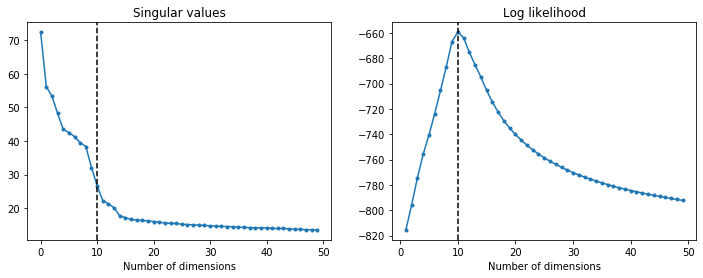

In [8]:
d = dim_select(As)

Create spectral embedding of the unfolded adjacency matrix $\mathbf{A}$ into $d=10$ dimensions. This number makes sense as it matches the number of communities we hope to find in the data; one for each classroom.

In [9]:
def right_embed(As, d):
    # Construct rectangular matrices
    if len(As.shape) == 2:
        As = np.array([As[:,:]])
    
    if len(As.shape) == 3:
        T = len(As)
        A = As[0,:,:]
        for t in range(1,T):
            A = np.block([A,As[t]])
    
    # Spectral embeddings
    UA, SA, VAt = np.linalg.svd(A); VA = VAt.T

    YA = np.zeros((T,n,d))
    for t in range(T):
        YA[t] = VA[t*n:(t+1)*n,0:d].dot(np.diag(np.sqrt(SA[0:d])))
        
    return YA

In [10]:
t0 = time.time()

YA = right_embed(As, d)

t1 = time.time()
print('Execution time:', np.round(t1-t0, 3), 'seconds')

Execution time: 2.961 seconds


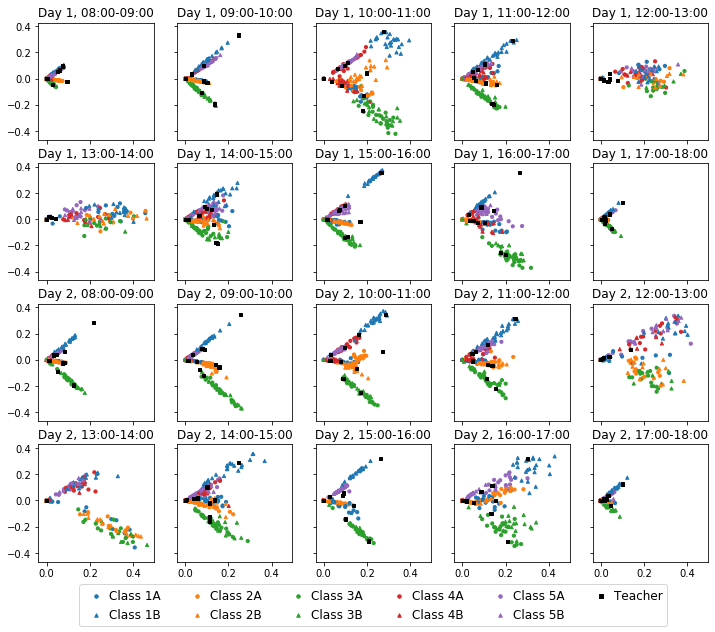

In [11]:
fig, axs = plt.subplots(4, 5, figsize=(12.0,9.6), sharex=True, sharey=True)

for m in ('o','^','s'):
    idx = np.where(Z_markers == m)[0]

    for t in range(T):
        i = int(t/5); j = t%5
        axs[i,j].scatter(YA[t,idx,0], YA[t,idx,1], marker=m, s=10, c=Z_colours[idx])
        
for t in range(T):
    i = int(t/5); j = t%5
    axs[i,j].set_title('Day ' + str(int(t/10)+1) + ', ' + str(t%10+8).zfill(2) + 
                       ':00-' + str(t%10+9).zfill(2) + ':00')

fig.legend(handles=handles, bbox_to_anchor=(0.432,0), loc='lower center', ncol=6, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.10);

Spherical coordinates result for degree-corrected SBM (Sanna Passino et al; 2020). We will use this version of the data for all of the following analysis.

In [12]:
def spherical_embed(x):
    d = len(x)
    theta = np.zeros(d-1)
    
    if x[0] > 0:
        theta[0] = np.arccos(x[1] / np.linalg.norm(x[:2]))
    else:
        theta[0] = 2*np.pi - np.arccos(x[1] / np.linalg.norm(x[:2]))
        
    for i in range(d-1):
        theta[i] = np.arccos(x[i+1] / np.linalg.norm(x[:(i+2)]))
        
    return theta

In [13]:
YD = np.zeros((T,n,9))

for t in range(T):
    for i in range(n):
        if np.linalg.norm(YA[t,i]) > 1e-10:
            YD[t,i] = spherical_embed(YA[t,i])

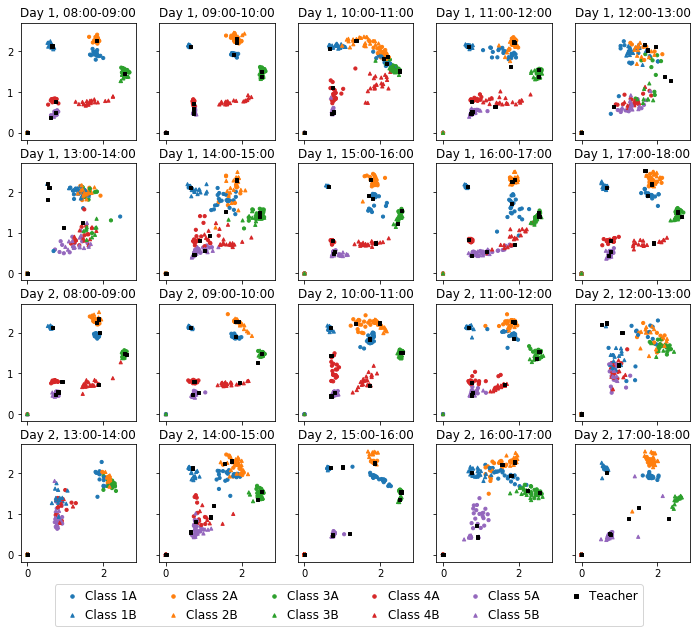

In [14]:
fig, axs = plt.subplots(4, 5, figsize=(12.0,9.6), sharex=True, sharey=True)

for m in ('o','^','s'):
    idx = np.where(Z_markers == m)[0]

    for t in range(T):
        i = int(t/5); j = t%5
        axs[i,j].scatter(YD[t,idx,0], YD[t,idx,1], marker=m, s=10, c=Z_colours[idx])
        
for t in range(T):
    i = int(t/5); j = t%5
    axs[i,j].set_title('Day ' + str(int(t/10)+1) + ', ' + str(t%10+8).zfill(2) + 
                       ':00-' + str(t%10+9).zfill(2) + ':00')

fig.legend(handles=handles, loc='lower center', ncol=6, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.10);

### Classroom classification

Concatenate all the temporal node embeddings into a single vector per node, $\mathbf{\Theta} = (\mathbf{\Theta}^{(1)} | \cdots | \mathbf{\Theta}^{(T)}) \in \mathbb{R}^{n \times 9T}$.

In [15]:
YD_concat = YD[0]

for t in range(1,T):
    YD_concat = np.block([YD_concat, YD[t]])

Fit a random forest to the concatenated embeddings for the student nodes to predict their true classroom. We generate 100 trees with a maximum of 5 features in each tree.

In [16]:
class_labels = [''] * n
for key, value in node_dict.items():
    class_labels[value] = id_dict[key]
    
class_labels = np.array(class_labels)

In [17]:
idx = np.where(class_labels != 'Teachers')[0]
YD_RF = RandomForestClassifier(max_features=5, n_estimators=100, random_state=0).fit(YD_concat[idx,:], class_labels[idx])

In [18]:
print('YD confusion matrix:')
print(metrics.confusion_matrix(class_labels[idx], YD_RF.predict(YD_concat[idx,:])))
ardi = metrics.adjusted_rand_score(class_labels[idx], YD_RF.predict(YD_concat[idx,:]))
print('Adjusted Rand index:', np.round(ardi,3))

YD confusion matrix:
[[23  0  0  0  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0  0]
 [ 0  0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0  0 21  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  0  0 22  0]
 [ 0  0  0  0  0  0  0  0  0 24]]
Adjusted Rand index: 1.0


Perhaps unsurprisingly given the plots of the spectral embedding above, the random forest perfectly distinguishes the 10 classrooms. We can get some idea of the robustness of the classifier but performing 10-fold cross validation.

In [19]:
t0 = time.time()

YD_RF_cvs = cross_val_score(YD_RF, YD_concat[idx,:], class_labels[idx], cv=10)
print('YD mean:', np.round(np.mean(YD_RF_cvs), 3))
print('YD st.dev.:', np.round(np.sqrt(np.var(YD_RF_cvs)), 3))

t1 = time.time()
print('Execution time:', np.round(t1-t0, 3), 'seconds')

YD mean: 0.983
YD st.dev.: 0.035
Execution time: 1.162 seconds


We can use this random forest to predict the classroom for each of the 10 teachers in the school (we reorder them below for a clearer diagram). We do not have truth data for this labelling but we would hope that one teacher is assigned to each classroom.

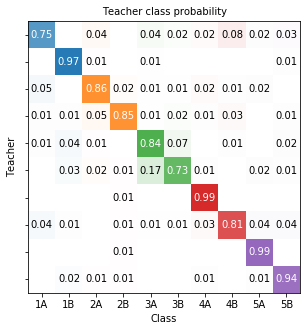

In [20]:
teachers = [188, 80, 104, 200, 168, 224, 130, 232, 180, 92]
teacher_prob = YD_RF.predict_proba(YD_concat[teachers,:])

fig, ax = plt.subplots(1, 1, figsize=(5.0,5.0))
classes = ['1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', '5A', '5B']

prob_colours = np.zeros((10,10,4))
ccols = categorical_cmap(5, 1, cmap='tab10')
for i in range(10):
    for j in range(10):
        prob_colours[i,j,0:3] = ccols[int(j/2)]
        prob_colours[i,j,3] = teacher_prob[i,j]

ax.imshow(prob_colours)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(classes)
ax.set_yticklabels(['']*10)
ax.set_xlabel('Class')
ax.set_ylabel('Teacher')

for i in range(10):
    for j in range(10):
        if i == j:
            text = ax.text(j, i, '%.2f'%teacher_prob[i,j], ha='center', va='center', color='w')
        elif teacher_prob[i,j] >= 0.01:
            text = ax.text(j, i, '%.2f'%teacher_prob[i,j], ha='center', va='center', color='k')

ax.set_title('Teacher class probability', fontsize=10);

Using maximum a posteriori assignment, one teacher is assigned to each classroom. There is some uncertainty, especially between teachers with students in the same school year, but this does not look obviously incorrect.

### Student clustering

This time overlay the node embeddings over all time into the same space, $\mathbf{\Theta} = (\mathbf{\Theta}^{(1) \top} | \cdots | \mathbf{\Theta}^{(T) \top})^\top \in \mathbb{R}^{nT \times 9}$.

In [21]:
YD_full = YD[0]

for t in range(1,T):
    YD_full = np.block([[YD_full], [YD[t]]])

Plot the nodes to show some evidence that classrooms cluster at least for some time periods. We ignore the points near zero.

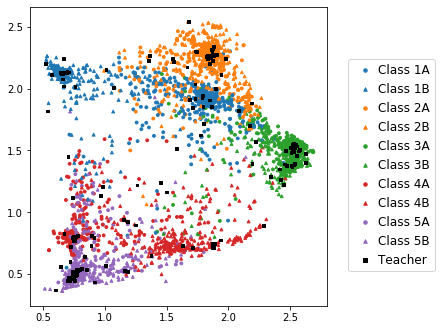

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6.5,5.5))

for m in ('o','^','s'):
    idx = np.where(np.array(list(Z_markers)*T) == m)[0]
    idx_nz = np.where(np.linalg.norm(YD_full[idx], axis=1) > 1e-10)[0]
    ax.scatter(YD_full[idx,0][idx_nz], YD_full[idx,1][idx_nz], marker=m, s=8, c=np.array(list(Z_colours)*T)[idx][idx_nz])
    
fig.legend(handles=handles, loc='center right', ncol=1, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(right = 0.76);

We want to fit a Gaussian mixture model to these 9-dimensional points to find structure in the embedding. Hopefully, we see students in the same classrooms clustering together but also detect temporal patterns of students returning to a similar spot in the embedding at different times. This is possible thanks to cross-sectional and longitudinal stability. We try 50 times to fit a Gaussian mixture model with 20-50 clusters, increasing in increments of 5 clusters. Using the Bayesian Information Criterion, we can find the best number of clusters $K$ to explain the observed data.

In [31]:
t0 = time.time()

idx_nz = np.where(np.linalg.norm(YD_full, axis=1) > 1e-10)[0]
YD_full_bic = []
K_range = range(20,51,5)

n_init = 50
for k in K_range:
    YD_full_bic.append(mixture.GaussianMixture(n_components=k, covariance_type='full', n_init=n_init).fit(YD_full[idx_nz]).bic(YD_full[idx_nz]))

t1 = time.time()
print('Execution time:', np.round(t1-t0, 3), 'seconds')

Execution time: 328.799 seconds


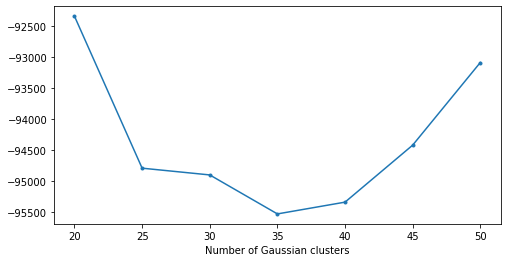

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8.0,4.0))

ax.plot(K_range, YD_full_bic, '.-')
ax.set_xticks(K_range)
ax.set_xlabel('Number of Gaussian clusters');

This time we find that the best Gaussian mixture model for the embedding has $K=35$ clusters, although our previous experiment showed $K=30$ clusters. We shall use the latter as this is approximately 3 clusters per classroom, and is something we can just about manage with 30 colours in Python. This could be modelled more precisely but it is enough to show the proof of concept of unfolded adjacency spectral embedding.

In [25]:
K = 30
n_init = 50
gmm_YD_full = mixture.GaussianMixture(n_components=K, covariance_type='full', n_init=n_init, random_state=1).fit(YD_full[idx_nz])

Assign each embedding to its maximum a posteriori cluster.

In [26]:
labels = np.array([[0 for _ in range(T)] for _ in range(n)])

for ni in range(n):
    for t in range(T):
        i = ni + t*n
        if np.linalg.norm(YD_full[i]) > 1e-10:
            labels[ni,t] = gmm_YD_full.predict(YD_full[i].reshape(1,-1)) + 1

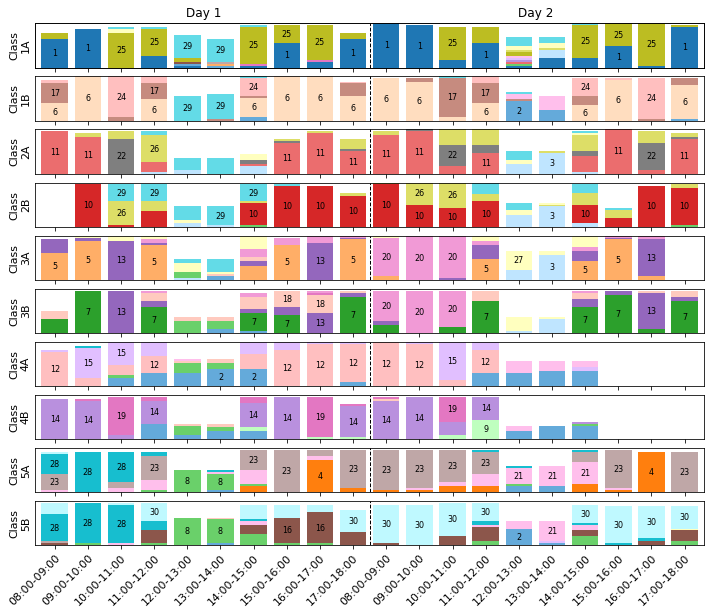

In [27]:
fig, axs = plt.subplots(10, 1, figsize=(12.0,9.6), sharex=True, sharey=True)
classes = ['1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', '5A', '5B']
bar_colours = categorical_cmap(10, 3, cmap='tab10')

times = ['08:00-09:00','09:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00',
         '13:00-14:00','14:00-15:00','15:00-16:00','16:00-17:00','17:00-18:00',
         '08:00-09:00','09:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00',
         '13:00-14:00','14:00-15:00','15:00-16:00','16:00-17:00','17:00-18:00']
delta = 0.6

for c in range(10):
    class_name = classes[c]
    
    cluster = []
    for key, value in node_dict.items():
        if id_dict[key] == class_name:
            cluster.append(value)        
    cluster = np.array(cluster)
    
    counts = np.zeros((K,T))
    for ni in cluster:
        for t in range(T):
            if labels[ni,t] > 0:
                counts[labels[ni,t]-1,t] += 1 / len(cluster)
    
    bottom = [0] * T
    for k in range(K):
        axs[c].bar(range(T), counts[k], bottom=bottom, color=bar_colours[k])
        # Following lines add labels if required
        for t in range(T):
            if counts[k,t] >= 0.35:
                axs[c].annotate(str(k+1), xy=(t, bottom[t]+counts[k,t]/2), ha='center', va='center', fontsize=8)
        bottom += counts[k]
    
    axs[c].plot([9.5,9.5], [0,1], 'k--', linewidth=1)
    axs[c].set_xlim((-delta,19+delta))
    axs[c].set_ylim((0,1))
    axs[c].set_yticks([])
    axs[c].set_yticklabels([])
    axs[c].set_ylabel('Class\n' + class_name, fontsize=11)

axs_top = axs[0].twiny()
axs_top.set_xlim((-delta,19+delta))
axs_top.tick_params(length=0)
axs_top.set_xticks([4.5,14.5])
axs_top.set_xticklabels(['Day 1', 'Day 2'], fontsize=12)

axs[9].set_xticks(range(T))
axs[9].set_xticklabels(times, rotation=45, fontsize=11, ha='right', va='top', rotation_mode='anchor');

Similarly to the classroom classfication task, we can also assign the teachers to their most likely cluster. How the teacher moves cluster over time can be matched to the previous barchart.

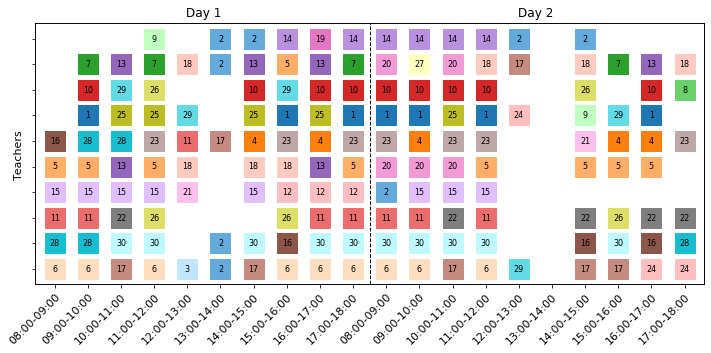

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12.0,4.8))
delta = 0.6

cluster = []
for key, value in node_dict.items():
    if id_dict[key] == 'Teachers':
        cluster.append(value)        
cluster = np.array(cluster)

for i in range(len(cluster)):
    for t in range(T):
        if labels[cluster[i],t] > 0:
            ax.scatter(t, i, marker='s', s=400, color=bar_colours[labels[cluster[i],t]-1])
            ax.annotate(str(labels[cluster[i],t]), xy=(t, i), ha='center', va='center', fontsize=8)

ax.plot([9.5,9.5], [-delta,len(cluster)-1+delta], 'k--', linewidth=1)
ax.set_xlim((-delta,19+delta))
ax.set_ylim((-delta,len(cluster)-1+delta))

ax_top = ax.twiny()
ax_top.set_xlim((-delta,19+delta))
ax_top.tick_params(length=0)
ax_top.set_xticks([4.5,14.5])
ax_top.set_xticklabels(['Day 1', 'Day 2'], fontsize=12)

ax.set_xticks(range(T))
ax.set_xticklabels(times, rotation=45, fontsize=11, ha='right', va='top', rotation_mode='anchor');
ax.set_yticks(range(len(cluster)))
ax.set_yticklabels([])
ax.set_ylabel('Teachers', fontsize=11);